In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM
from tensorflow.keras.models import Sequential
import importlib
import make_data as md
importlib.reload(md)
import make_model as mm
importlib.reload(mm)
import optuna
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from datetime import datetime as dt
from datetime import timedelta

In [5]:
data, data_np = md.load_data("日経平均00-22日足.csv","日付")

In [15]:
data["rsi9"]

日付
2022-05-27    0.000000
2022-05-26    0.000000
2022-05-25    0.469024
2022-05-24    0.198639
2022-05-23    0.050540
                ...   
2002-09-18   -0.250535
2002-09-17   -0.136549
2002-09-13   -0.126647
2002-09-12    0.044513
2002-09-11    0.035691
Name: rsi9, Length: 4822, dtype: float64

In [10]:
data["アッパーエンベロープー終値"] = md.upper_envelope(data["終値"], data["5日平均"], 1)
data["ロワーエンベロープー終値"] = md.lower_envelope(data["終値"], data["5日平均"], 1)
data["5日平均-25日平均"] = md.average_line_difference(data["5日平均"], data["25日平均"])
data["25日平均-75日平均"] = md.average_line_difference(data["25日平均"], data["75日平均"])
data_5_25 = md.cross(data["5日平均-25日平均"])
data_25_75 = md.cross(data["25日平均-75日平均"])
upper_bband, lower_bband = md.bband(data["終値"] )
data["アッパーボリンジャーバンド"] = upper_bband
data["ロワーボリンジャーバンド"] = lower_bband
data["ボリンジャーバンド差"] = md.average_line_difference(data["アッパーボリンジャーバンド"] ,data["ロワーボリンジャーバンド"])
data_bband_border = md.bband_border(data["アッパーボリンジャーバンド"], data["ロワーボリンジャーバンド"], data["高値"], data["安値"])
data["MACD"] =  [x - y for (x, y) in zip(md.ema(data["終値"], 9), md.ema(data["終値"], 26))]
data["シグナルMACD"] = md.average_line(data["MACD"],9)
data_macdcross = md.cross(md.average_line_difference(data["MACD"], data["シグナルMACD"]))
data_up_or_down = md.up_or_down(data["終値"])
data_close=data["終値"]

C:\Users\track\Desktop\Machine Learning\株価予測\make_data.py:95: RuntimeWarning: invalid value encountered in sign
  asign = np.sign(data_differ)


In [11]:
data = md.standardization(data)

In [14]:
data_days, data_weeks = md.data_from_year(data.index)
#data["年始からの日"] = data_days
#data["年始からの週"] = data_weeks
data['5-25クロス'] = data_5_25
data['25-75クロス'] = data_25_75
data["ボリンジャーバンドボーダー"] = data_bband_border
data["rsi9"] = md.rsi(data["終値"],9)
data["rsi14"] = md.rsi(data["終値"],14)
data["MACDクロス"] = data_macdcross

In [16]:
data = data.drop(["高値","安値","5日平均.1","25日平均.1", '5日平均', '25日平均', '75日平均','アッパーボリンジャーバンド', 'ロワーボリンジャーバンド'], axis=1)

In [17]:
data["騰落"]=data_up_or_down
data = data.dropna()
data_np = data.to_numpy()

In [60]:
seq_len = 30
epoch = 500
x_train, y_train, x_test, y_test= mm.data_split(data_np,seq_len=seq_len, y=-1)

In [61]:
model = mm.build_model([data.shape[1],30,300,1])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
h=model.fit(x_train, y_train, batch_size=512, epochs=epoch, validation_split=0.05, callbacks=[callback])

ValueError: Unknown activation function: leakyrelu

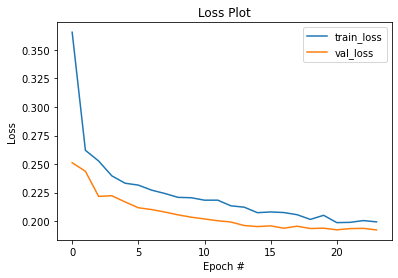

In [57]:
h = pd.DataFrame(h.history)
epochs = np.arange(0, len(h["loss"]))
plt.plot(epochs, h["loss"], label="train_loss")
plt.plot(epochs, h["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
#plt.savefig("Loss.png")
plt.show()

In [58]:
mm.evalution(x_test,y_test,model)

混同行列[[195  53]
 [ 76 151]]
正解率は0.728421052631579 適合率は0.7401960784313726 再現率は0.6651982378854625 F値は0.7006960556844547


In [54]:
x_test_close=data_close[(len(data_close)-len(x_test))-1:-1]
value = mm.baibai(x_test,model,x_test_close)
print(value)

354.70000000000437


In [49]:
model.save("my_model2")
#reconstructed_model = tf.keras.models.load_model("my_model")
#mm.draw_tran_result(reconstructed_model, x_test, y_test)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: my_model2\assets


In [16]:
x_train_sfs=data.iloc[:,:-1]
y_train_sfs=data.iloc[:,-1]

sfs1 = SFS(RandomForestClassifier(), # 使う学習器
           k_features=10, #特徴をいくつまで選択するか
           forward=True, #Trueでforward selectionになる。Falseでback
           floating=False, #後に説明するが、forward selectionの亜種を行うためのもの。
           verbose=2, #実行時のlogをどれだけ詳しく表示するか
           scoring='accuracy', # 評価指標
           cv=5) #クロスバリデーション
#ちなみにクロスバリデーションをしない(cv=0)とすると、最終的に選ばれる特徴が変わります。

sfs1 = sfs1.fit(x_train_sfs,y_train_sfs)

selected_feat = x_train_sfs.columns[list(sfs1.k_feature_idx_)]


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:  1.1min finished

[2022-06-13 17:19:19] Features: 1/10 -- score: 0.5242680540924043[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed:   50.9s finished

[2022-06-13 17:20:10] Features: 2/10 -- score: 0.5105736030787091[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  13 out of  13 | elapsed:   48.1s finished

[2022-06-13 17:20:58] Features: 3/10 -- score: 0.5157654849181948[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  

In [17]:
sfs1.subsets_

{1: {'feature_idx': (11,),
  'cv_scores': array([0.52227979, 0.50569948, 0.53008299, 0.53630705, 0.52697095]),
  'avg_score': 0.5242680540924043,
  'feature_names': ('rsi8',)},
 2: {'feature_idx': (11, 13),
  'cv_scores': array([0.51606218, 0.51917098, 0.51763485, 0.49273859, 0.50726141]),
  'avg_score': 0.5105736030787091,
  'feature_names': ('rsi8', 'rsi16')},
 3: {'feature_idx': (7, 11, 13),
  'cv_scores': array([0.51088083, 0.49948187, 0.52385892, 0.52593361, 0.5186722 ]),
  'avg_score': 0.5157654849181948,
  'feature_names': ('出来高', 'rsi8', 'rsi16')},
 4: {'feature_idx': (7, 11, 13, 14),
  'cv_scores': array([0.5357513 , 0.50880829, 0.53215768, 0.52489627, 0.51037344]),
  'avg_score': 0.5223973942768688,
  'feature_names': ('出来高', 'rsi8', 'rsi16', 'rsi20')},
 5: {'feature_idx': (7, 9, 11, 13, 14),
  'cv_scores': array([0.53367876, 0.51709845, 0.52697095, 0.51763485, 0.51348548]),
  'avg_score': 0.5217736976759185,
  'feature_names': ('出来高', '25日平均.1', 'rsi8', 'rsi16', 'rsi20')},
 